# Spanish High Schools Network Analysis

**Abstract**. Network theory serves as a vital tool in understanding complex systems, transcending disciplinary boundaries to offer insights into various fields of research. High schools, as microcosms of society, present intriguing subjects for network analysis, reflecting broader societal structures and dynamics. In this study, we conduct a comprehensive structural analysis of a Spanish high school network, aiming to elucidate the implications of its structure on social interactions. Our analysis reveals how the network’s topology intricately captures sociological information, reflecting the underlying social dynamics within the educational setting. Ultimately, this study underscores the relevance of network theory in unraveling the complexities of social structures, offering valuable unbiased insights into the fundamental dynamics of human social behaviour.

### Notebook Contents
In this notebook we present structural analysis of a [Spanish high school network](https://networks.skewed.de/net/spanish_highschools). In particular, we will consider the 6th network in the dataset. We have found that the 11_x for $x \in \{1, 2, 3, 4, 5, 6, 7, 8, 9, 10\}$ networks have duplicated edges, so we will not consider them. The following code can be used also for networks 1 & 2.

In [42]:
# Import necessary packages
import zipfile, random, networkx as nx, pandas as pd, numpy as np, matplotlib.pyplot as plt, scipy.stats as st, seaborn as sns, ast, warnings 
from itertools import combinations
from scipy.linalg import expm
from scipy.stats import kstest, poisson
from scipy.optimize import curve_fit
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names

# Plot aesthetics
from matplotlib.ticker import AutoMinorLocator
plt.rcParams.update({"font.family": "Times New Roman", "mathtext.fontset": "cm"})
plt.rcParams.update({"lines.linewidth": 0.8, "lines.markersize": 0.8})
plt.rcParams['axes.labelsize'] = 12

In [10]:
# Upload network
path_to_zipped_file = "6.csv.zip" 

def upload_network(path_to_zipped_file, dataframe = False):
    """Uploads a network from a zipped file containing the edges, nodes, and graph properties in csv format.

    Args:
        path_to_zipped_file (string): Path to the zipped file containing the network data.
        dataframe (bool, optional): In case you want to explore the data, returns the data frame. Defaults to False.

    Returns:
        NetworkX graph object if dataframe is False, otherwise returns the graph and the dataframes for edges and nodes.
    """
    # Open zip with network files
    with zipfile.ZipFile(path_to_zipped_file) as z:
        # Edges 
        with z.open('edges.csv') as f:
            df_edges = pd.read_csv(f)
            column_names = df_edges.columns
            # create network from edge list
            G = nx.from_pandas_edgelist(df_edges, column_names[0], column_names[1], edge_attr= True, create_using=nx.DiGraph()) # for directed graph

        # Nodes
        with z.open('nodes.csv') as f:
            df_nodes = pd.read_csv(f)
            column_names = df_nodes.columns
            df_nodes = df_nodes.rename(columns={column_names[0]: "node"})  # Rename the column

            for att in list(df_nodes.columns[1:]):
                att_dict = pd.Series(df_nodes[att].values, index=df_nodes.node).to_dict()
                nx.set_node_attributes(G, att_dict, att)
        
        # Graph Properties
        parsed_data = []
        with z.open('gprops.csv') as f:
            for line in f:
                decoded_line = line.decode('utf-8')
                if not decoded_line.strip() or decoded_line.startswith('#'):
                    continue

                split_line = decoded_line.split(',', 1)

                if len(split_line) == 2:
                    key, value = split_line
                    value = value.strip().strip('"')
                    parsed_data.append([key.strip(), value])

        # Adding the data to the network object
        for prop, value in parsed_data:
            G.graph[prop] = value
    
    if dataframe: return G, df_edges, df_nodes
    
    return G

G, df_edges, df_nodes = upload_network(path_to_zipped_file, dataframe = True)

In [11]:
# Sanity checks
print(G.is_directed())
print(G.edges(data=True)) 
print(G.nodes(data=True)) 
print(G.graph)
print(G.number_of_nodes(), G.number_of_edges(), df_edges.shape, df_nodes.shape)

True
[(0, 1, {' weight': 1}), (0, 2, {' weight': 1}), (0, 3, {' weight': -2}), (0, 4, {' weight': 1}), (0, 5, {' weight': -1}), (0, 6, {' weight': 1}), (0, 7, {' weight': -2}), (0, 8, {' weight': 2}), (0, 9, {' weight': 1}), (0, 10, {' weight': 1}), (0, 11, {' weight': -1}), (0, 12, {' weight': 1}), (0, 13, {' weight': 2}), (0, 14, {' weight': 1}), (0, 15, {' weight': 2}), (0, 16, {' weight': 1}), (0, 17, {' weight': 2}), (2, 1, {' weight': 1}), (2, 0, {' weight': 1}), (2, 6, {' weight': 2}), (2, 8, {' weight': 1}), (2, 9, {' weight': 1}), (2, 22, {' weight': 2}), (2, 12, {' weight': 2}), (2, 13, {' weight': 1}), (2, 14, {' weight': 2}), (2, 17, {' weight': 1}), (3, 1, {' weight': -1}), (3, 19, {' weight': 2}), (3, 0, {' weight': 1}), (3, 18, {' weight': 1}), (3, 4, {' weight': 2}), (3, 7, {' weight': 2}), (3, 20, {' weight': 2}), (3, 2, {' weight': 2}), (3, 23, {' weight': 2}), (3, 5, {' weight': 2}), (3, 8, {' weight': 2}), (3, 6, {' weight': 1}), (3, 11, {' weight': 2}), (3, 21, {' 

In order to do the structural analysis, we will not consider the weights of the edges, and we will consider the network as undirected.

In [13]:
# Convert the graph to Undirected (Symmetrize)
G = G.to_undirected()

# Sanity checks
print(G.number_of_nodes(), G.number_of_edges())
print(type(G))

534 9527
<class 'networkx.classes.graph.Graph'>


# 1. General Network Metrics
In this section we will calculate some general metrics of the network. Apart from the bipartivity index, all of these metrics are calculated using the `networkx` library.

In [14]:
# General Network Properties Functions
def bipartivity_index(graph):
    """This function calculates the bipartivity index of a graph as defined in Ernesto Estrada, Philip A. Knight (A First Course in Network Theory) (18.13) equation. 

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object.

    Returns:
        float: Bipartivity index of the graph.
        
    Comment: NetworkX has the built-in 'spectral_bipartivity' function, but it is defined as (18.10) from the same book.
    """
    A = nx.adjacency_matrix(graph).toarray()

    # Calculate the matrix exponential for A and -A
    exp_A = expm(A); exp_neg_A = expm(-A)

    # Calculate the traces of both exp_A and exp_neg_A
    trace_exp_A = np.trace(exp_A)
    trace_exp_neg_A = np.trace(exp_neg_A)

    return trace_exp_neg_A / trace_exp_A

def basic_properties(graph, verbose = False):
    """
    This function computes various basic properties of a given graph using NetworkX library and NumPy.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph whose properties are to be computed.
        verbose (bool, optional): If True, prints the computed properties. Defaults to False.

    Returns:
        tuple or prints: If verbose is False, returns a tuple containing the following properties in order: 
                        (number_of_nodes, number_of_edges, average_degree, standard_deviation_of_degree,
                        density, average_shortest_path_length, diameter, average_clustering_coefficient,
                        transitivity, degree_assortativity_coefficient, bipartivity_index).
                        If verbose is True, prints the computed properties and does not return anything.
    """
    n,m = graph.number_of_nodes(), graph.number_of_edges()
    list_of_degrees = list(dict(graph.degree()).values())
    k_avg = np.mean(list_of_degrees)
    k_std = np.std(list_of_degrees)
    density = nx.density(graph)
    avg_path_length = nx.average_shortest_path_length(graph)
    diameter = nx.diameter(graph)
    avg_clustering_coefficient = nx.average_clustering(graph)
    transitivity = nx.transitivity(graph)
    r = nx.degree_assortativity_coefficient(graph)
    b = bipartivity_index(graph)
    
    if verbose: print(f"n={n}, m={m}, <k>={k_avg}, σ_k={k_std}, ρ={density}, l = {avg_path_length}, D = {diameter}, C={avg_clustering_coefficient}, T={transitivity}, r={r}, b_e={b}")
    
    if not verbose: return n, m, k_avg, k_std, density, avg_path_length, diameter, avg_clustering_coefficient, transitivity, r, b

basic_properties(G, verbose = True)
G_properties = basic_properties(G)

n=534, m=9527, <k>=35.6816479400749, σ_k=15.208776797175899, ρ=0.06694493046918369, l = 2.6502167787451425, D = 5, C=0.52390834264572, T=0.44511450362214444, r=-0.05538635369871248, b_e=1.8325187965319985e-15


## Centrality Measures

In [40]:
def centralities_to_df(top_N_centralities):
    """
    This function converts the dictionary of top N nodes for each centrality measure to a pandas DataFrame.

    Args:
        top_N_centralities (dict): Dictionary containing the top N nodes for each centrality measure. 
        Keys are the abbreviations of the centrality measures ('DC' for Degree Centrality, 'CC' for Closeness Centrality, etc.), 
        and values are lists of tuples, each tuple containing a node identifier and its corresponding centrality value.

    Returns:
        pandas.core.frame.DataFrame: DataFrame containing the top N nodes for each centrality measure.
    """
    data = {measure: [node[0] for node in values] for measure, values in top_N_centralities.items()}
    data['Rank'] = list(range(1, len(next(iter(top_N_centralities.values()))) + 1))  # Generating ranks

    # Reordering columns to have 'Rank' as the first column
    column_order = ['Rank'] + list(top_N_centralities.keys())
    return  pd.DataFrame(data)[column_order]

# Function for calculating the 25 most central nodes in the network according to 7 different centrality measures
def centrality_calculations(graph, N = 25, verbose = False, LaTeX = False):
    """
    This function computes various centrality measures for the nodes in a given graph and optionally prints or returns the top N nodes for each centrality measure.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        N (int, optional): Number of top nodes to be calculated for each centrality measure. Defaults to 25.
        verbose (bool, optional): If True, prints the top N nodes for each centrality measure. Defaults to False.
        LaTeX (bool, optional): If True, generates a LaTeX table containing the top N nodes for each centrality measure and prints it. Defaults to False.

    Returns:
        dict or None: If verbose and LaTeX are False, returns a dictionary containing the top N nodes for each centrality measure. 
                    Keys are the abbreviations of the centrality measures ('DC' for Degree Centrality, 'CC' for Closeness Centrality, etc.), 
                    and values are lists of tuples, each tuple containing a node identifier and its corresponding centrality value.
                    If verbose or LaTeX is True, prints the top N nodes for each centrality measure and returns None.
    """
    # Dictionary of centrality measures
    centrality_measures = {
        'DC': nx.degree_centrality,
        'CC': nx.closeness_centrality,
        'BC': nx.betweenness_centrality,
        'KC': lambda G: nx.katz_centrality(G, alpha=0.001), # Katz centrality with damping factor
        'EC': nx.eigenvector_centrality,
        'PC': nx.pagerank,
        'SC': nx.subgraph_centrality,
    }

    # Calculating and printing top N nodes for each centrality measure
    top_N_centralities = {}

    for name, function in centrality_measures.items():
        centrality = function(graph)
        top_N = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:N]
        top_N_centralities[name] = top_N
        if verbose: print(f"Top {N} Nodes by {name.capitalize()} Centrality:", top_N)
        
    if LaTeX:
        df = centralities_to_df(top_N_centralities)

        # Convert the DataFrame to LaTeX
        latex_code = df.to_latex(index=False)
        print(latex_code)
    
    if not (verbose or LaTeX): return top_N_centralities
    
     
centrality_calculations(G, N = 10, verbose = True, LaTeX = True)

Top 10 Nodes by Dc Centrality: [(288, 0.3227016885553471), (145, 0.225140712945591), (530, 0.22326454033771106), (198, 0.20825515947467166), (227, 0.18198874296435272), (299, 0.17448405253283303), (71, 0.150093808630394), (153, 0.150093808630394), (468, 0.14634146341463414), (350, 0.14634146341463414)]
Top 10 Nodes by Cc Centrality: [(288, 0.5139826422372228), (299, 0.48720292504570384), (357, 0.47168141592920354), (289, 0.4675438596491228), (468, 0.4650959860383944), (225, 0.4501689189189189), (348, 0.44978902953586497), (283, 0.4482758620689655), (133, 0.4475230898404702), (380, 0.4412251655629139)]
Top 10 Nodes by Bc Centrality: [(288, 0.12491180187039198), (299, 0.04384255046249281), (153, 0.03163011129746333), (468, 0.031048102602430017), (99, 0.026875290894698863), (133, 0.025247926308293395), (225, 0.023483243140032035), (223, 0.02334152028110344), (95, 0.020163815040212595), (237, 0.019516999416131383)]
Top 10 Nodes by Kc Centrality: [(288, 0.049140753767673066), (145, 0.046935

Now we analyze the pairwise comparison of the centrality measures. 

In [46]:
top_N_centralities = centrality_calculations(G)
df = centralities_to_df(top_N_centralities)

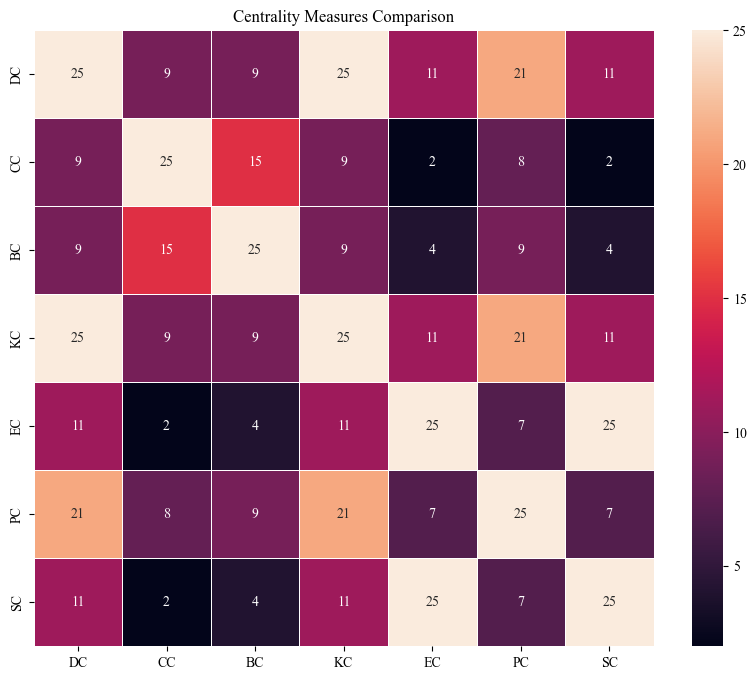

In [43]:
def centrality_comparison_heatmap(top_N_centralities, save=False, file_path="Figures/Centrality_Comparison.png"):
    """
    Generates a heatmap comparing different centrality measures based on their top-ranked nodes.

    Parameters:
    top_N_centralities (dict): A dictionary where keys are centrality measures and values are lists of (node, centrality) tuples.
    save (bool): If True, saves the heatmap to a file.
    file_path (str): The file path for saving the heatmap if 'save' is True.
    """
    
    if not isinstance(top_N_centralities, dict) or not top_N_centralities:
        raise ValueError("top_N_centralities must be a non-empty dictionary.")

    # Prepare data
    df = centralities_to_df(top_N_centralities)

    # Precompute sets for each centrality measure
    sets = {method: set(df[method]) for method in top_N_centralities.keys()}

    # Initialize comparison matrix
    matrix_size = len(top_N_centralities)
    comparison_matrix = np.zeros((matrix_size, matrix_size), dtype=int)

    # Populate the comparison matrix
    for (i, method_i), (j, method_j) in combinations(enumerate(top_N_centralities.keys()), 2):
        shared_elements = len(sets[method_i].intersection(sets[method_j]))
        comparison_matrix[i, j] = comparison_matrix[j, i] = shared_elements

    # Diagonal (self-comparison)
    methods = list(top_N_centralities.keys())  # Convert keys to list
    for i in range(matrix_size):
        comparison_matrix[i, i] = len(sets[methods[i]])

    # Convert to DataFrame
    comparison_df = pd.DataFrame(comparison_matrix, index=top_N_centralities.keys(), columns=top_N_centralities.keys())

    # Create and display the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(comparison_df, annot=True, linewidths=0.7)
    plt.title("Centrality Measures Comparison")
    
    if save: plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
centrality_comparison_heatmap(top_N_centralities)

In [47]:
def shared_nodes(df):
    """
    This function calculates and prints the number of shared nodes between pairs of columns in a DataFrame, and then calculates and prints the average number of shared nodes across all column pairs.

    Args:
        df (pandas.DataFrame): The input DataFrame assumed to have columns with some structure.

    Returns:
        None: This function only prints information about shared nodes and does not return any value.
    """
    # Get the column names
    columns = df.columns.drop('Rank')
    shared_nodes = {}

    # Iterate over pairwise combinations of columns
    for i in range(len(columns)):
        for j in range(i+1, len(columns)):
            # Get the unique nodes in each column
            nodes_i = set(df[columns[i]])
            nodes_j = set(df[columns[j]])
            
            # Find the shared nodes
            shared = nodes_i.intersection(nodes_j)
            
            # Store the shared nodes in the dictionary
            shared_nodes[(columns[i], columns[j])] = shared

    # Print the number and the shared nodes for each pairwise combination
    for pair, nodes in shared_nodes.items():
        print(f"Shared nodes between {pair[0]} and {pair[1]}: {len(nodes)}")
        print(f"Nodes: {nodes}")
        
    # Calculate the total number of combinations
    total_combinations = len(shared_nodes)

    # Calculate the sum of shared nodes
    sum_shared_nodes = sum(len(nodes) for nodes in shared_nodes.values())

    # Calculate the average number of shared nodes
    average_shared_nodes = sum_shared_nodes / total_combinations

    print(f"Average number of shared nodes: {average_shared_nodes}")


    # Initialize an empty set to store the shared nodes
    shared_nodes = set(df[columns[0]])

    # Iterate over the remaining columns
    for column in columns[1:]:
        # Get the unique nodes in the current column
        nodes = set(df[column])
        
        # Find the shared nodes with the previous columns
        shared_nodes = shared_nodes.intersection(nodes)

    # Print the number and the shared nodes
    print(f"Number of nodes present in all methods: {len(shared_nodes)}")
    print(f"Nodes: {shared_nodes}")
    
shared_nodes(df)

Shared nodes between DC and CC: 9
Nodes: {288, 225, 133, 454, 299, 530, 468, 350, 223}
Shared nodes between DC and BC: 9
Nodes: {288, 225, 133, 454, 299, 530, 468, 153, 223}
Shared nodes between DC and KC: 25
Nodes: {133, 145, 530, 153, 28, 29, 159, 288, 161, 299, 45, 198, 71, 454, 456, 468, 212, 342, 350, 223, 225, 227, 231, 242, 498}
Shared nodes between DC and EC: 11
Nodes: {161, 223, 225, 227, 198, 231, 145, 242, 212, 153, 159}
Shared nodes between DC and PC: 21
Nodes: {133, 145, 530, 153, 28, 29, 288, 299, 45, 198, 71, 456, 454, 468, 342, 350, 225, 227, 231, 498, 242}
Shared nodes between DC and SC: 11
Nodes: {161, 223, 225, 227, 198, 231, 145, 242, 212, 153, 159}
Shared nodes between CC and BC: 15
Nodes: {288, 289, 225, 163, 133, 454, 357, 359, 299, 530, 467, 468, 283, 348, 223}
Shared nodes between CC and KC: 9
Nodes: {288, 225, 133, 454, 299, 530, 468, 350, 223}
Shared nodes between CC and EC: 2
Nodes: {225, 223}
Shared nodes between CC and PC: 8
Nodes: {288, 225, 133, 454, 299

# 2. Degree Distribution
In this section we will calculate the degree distribution of the network and plot it. We will also find the best fit for the degree distribution.

In [48]:
# Main Functions
def PDF(graph):
    """
    This function computes the Probability Density Function (PDF) of the degree distribution for a given graph.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.

    Returns:
        tuple: A tuple containing two arrays:
            - k_vals: An array representing the range of degree values from the minimum to the maximum degree in the graph.
            - pdf_vals: An array representing the probability density function values for each degree value in k_vals,
                        normalized by the total number of nodes in the graph.
    """
    degs = np.array([degree for node, degree in graph.degree()]) # numpy array of degrees of each node
    k_vals = np.arange(np.min(degs), np.max(degs) + 1) # Range of k values from 0 to max degree
    n_ks = np.array([np.count_nonzero(degs == k) for k in k_vals]) # Count occurrences of each degree in the range
    return k_vals, n_ks/graph.number_of_nodes()

def CDF(graph):
    """
    This function computes the Cumulative Distribution Function (CDF) of the degree distribution for a given graph.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.

    Returns:
        tuple: A tuple containing two arrays:
            - k_vals: An array representing the range of degree values from the minimum to the maximum degree in the graph.
            - cdf_vals: An array representing the cumulative distribution function values for each degree value in k_vals,
                        indicating the probability that a randomly selected node has a degree less than or equal to the degree value.
    """
    k_vals, deg_dist = PDF(graph)
    CDF = np.cumsum(deg_dist)
    return k_vals, CDF

def best_fit_distribution(data, bins=200):
    """
    This function models given data by finding the best-fit distribution using SciPy library.
    It estimates distribution parameters from the data and compares different distributions to find the one that best fits the data.

    Args:
        data (pandas series): The input data to be modeled.
        bins (int, optional): Number of bins for the histogram of the original data. Defaults to 200.

    Returns:
        list: A list containing tuples of the form (distribution, parameters, sum of squared errors) sorted in ascending order of the sum of squared errors.
            Each tuple represents a fitted distribution, where:
            - distribution: The SciPy distribution object representing the fitted distribution.
            - parameters: The parameters estimated for the fitted distribution.
            - sum of squared errors: The sum of squared errors between the fitted probability density function (PDF) and the original data.
    
    Resource: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python/69930160#69930160
    """
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    distributions = [d for d in _distn_names if not d in ['levy_stable', 'studentized_range']] # remove these distributions
    best_distributions = []
    
    # Estimate distribution parameters from data
    for ii, distribution in enumerate(distributions):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))
        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # Fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]; loc = params[-2]; scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # identify if this distribution is better
                best_distributions.append((distribution, params, sse))

        except Exception:
            pass
    
    return sorted(best_distributions, key=lambda x:x[2])

def plotting_fitting(graph, best_distributions, save = False, filename = "degree_distribution.png"):
    """
    This function plots the empirical and theoretical probability density functions (PDF) and cumulative distribution functions (CDF) for the degree distribution of a given graph, along with the best-fitting distributions obtained from a list of best distributions.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        best_distributions (list): A list containing tuples of the form (distribution, parameters, sum of squared errors) representing the best-fitting distributions.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.
        filename (str, optional): The filename for the saved image if 'save' parameter is set to True. Defaults to "degree_distribution.png".

    Returns:
        None: This function only displays the plot and does not return any value.
    """
    k_values, p = PDF(graph)
    _, F = CDF(graph)
    list_of_degrees = [degree for node, degree in graph.degree()] # For fitting

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot the empirical PDF & CDF
    axs[0].bar(k_values, p, width=0.8, color='gray', label='Empirical')
    axs[1].step(k_values, F, where='post', color='gray', label='Empirical')

    for distribution, params, _ in best_distributions:
        # Calculate PDF and CDF for each distribution
        pdf = distribution.pdf(k_values, *params[:-2], loc=params[-2], scale=params[-1])
        cdf = distribution.cdf(k_values, *params[:-2], loc=params[-2], scale=params[-1])

        # Plot the theoretical PDF & CDF
        label = f'{distribution.name}' 
        axs[0].plot(k_values, pdf, label=f'{distribution.name}'.capitalize())
        axs[1].plot(k_values, cdf, label=f'{distribution.name}'.capitalize())

        # Perform K-S test and print results
        ks_stat, ks_pvalue = kstest(list_of_degrees, distribution.name, args=params)
        print(f"K-S Statistic ({distribution.name}): {ks_stat}, p-value: {ks_pvalue}")

    # Set titles, labels, and legends
    axs[0].set_ylabel('PDF')
    axs[0].legend()
    axs[0].xaxis.set_minor_locator(AutoMinorLocator())
    axs[0].yaxis.set_minor_locator(AutoMinorLocator())

    axs[1].set_xlabel(r'$k$')
    axs[1].set_ylabel('CDF')
    axs[1].xaxis.set_minor_locator(AutoMinorLocator())
    axs[1].yaxis.set_minor_locator(AutoMinorLocator())

    plt.tight_layout()
    if save: plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

In [49]:
data = pd.Series([degree for node, degree in G.degree()]) # for fitting
best_distibutions_G = best_fit_distribution(data)

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

mielke with parameters: (4.356074855040214, 5.136054526505195, -0.12148129803995077, 35.11021206102694)
genhyperbolic with parameters: (-2.271184751319427, 0.9772976958711697, 0.9772976376826197, 28.087802271826334, 19.45200383344691)
exponnorm with parameters: (1.6880959817956516, 23.804057239567133, 7.036076951050818)
K-S Statistic (mielke): 0.0339141046100942, p-value: 0.5591909535772801


K-S Statistic (genhyperbolic): 0.03777453410311554, p-value: 0.42087463334842967
K-S Statistic (exponnorm): 0.039569894334687716, p-value: 0.3636807578443464


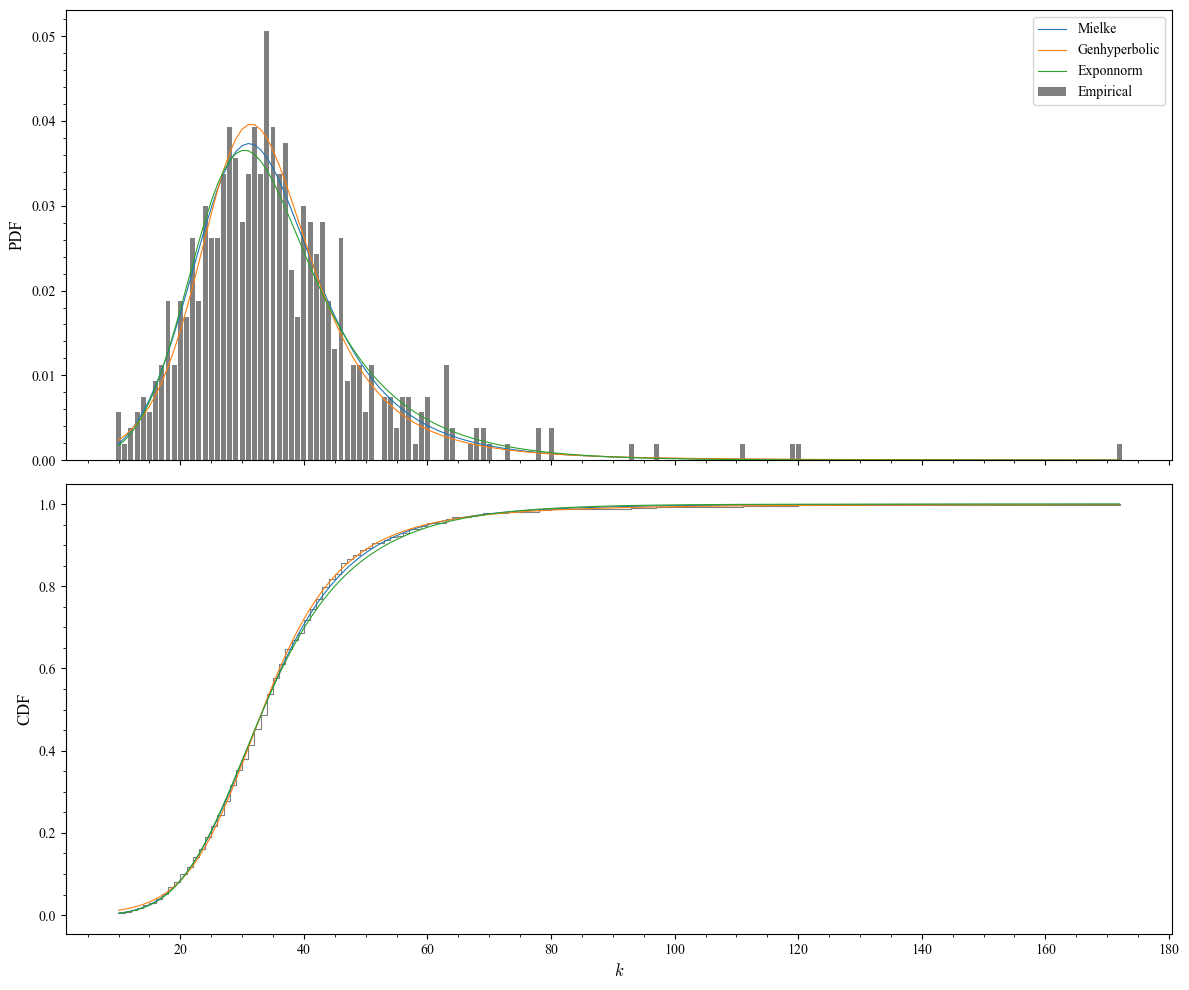

In [50]:
# Plotting the podium of non-redundant distributions
dists = [best_distibutions_G[0], best_distibutions_G[3], best_distibutions_G[5]]
for dist, params, _ in dists: print(f"{dist.name} with parameters: {params}")
plotting_fitting(G, dists)

# 3. Community Detection

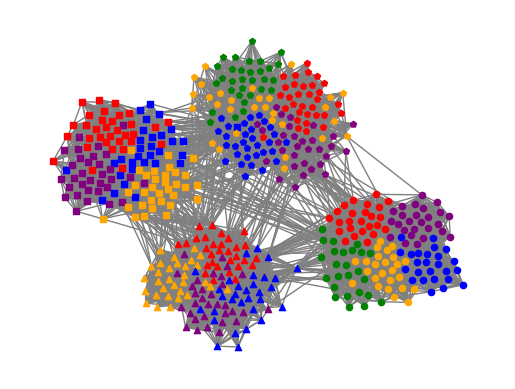

In [56]:
def plot_specifics(graph):
    """
    This function extracts specific attributes and node positions from a given graph.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.

    Returns:
        tuple: A tuple containing three dictionaries:
            - node_positions: A dictionary mapping node identifiers to their positions in the graph layout.
            - curso_attr: A dictionary mapping node identifiers to their 'Curso' attribute values.
            - grupo_attr: A dictionary mapping node identifiers to their 'Grupo' attribute values.
    """
    node_positions_str = nx.get_node_attributes(graph, ' _pos')
    node_positions = {}
    for node, array_str in node_positions_str.items():
        safe_str = array_str.replace('array', '')
        array_list = ast.literal_eval(safe_str)
        node_positions[node] = array_list
        
    curso_attr = nx.get_node_attributes(graph, ' Curso')
    grupo_attr = nx.get_node_attributes(graph, ' Grupo')

    return node_positions, curso_attr, grupo_attr
    

def plot_course_class_network(graph, save=False):
    """
    This function plots a network representation of a course-class graph, where nodes represent students and edges represent relationships between students. Each node is colored based on the class group ('Grupo') attribute and shaped based on the course ('Curso') attribute of the student.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the course-class network graph.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.

    Returns:
        None: This function only displays the plot and does not return any value.
    """
    node_positions, curso_attr, grupo_attr = plot_specifics(graph)

    curso_shapes = {1: '^', 2: 's', 3: 'p', 6: 'o'}
    grupo_colors = {'A': 'red', 'B': 'orange', 'E': 'green', 'D': 'blue', 'C': 'purple'}

    for node in graph.nodes():
        curso = curso_attr[node]
        grupo = grupo_attr[node]
        shape = curso_shapes.get(curso, 'o')  # Default to 'o' (circle) if curso not found
        color = grupo_colors.get(grupo, 'gray')  # Default to 'gray' if grupo not found
        pos = node_positions
        nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_size=20, node_color=color, node_shape=shape)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, edge_color='gray')
    plt.axis('off')
    if save: plt.savefig("Figures/Student_Network_course_class.png", dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_course_class_network(G, save=False)

Number of communities: 4.0 +/- 0.0
Modularity of the partition: 0.7138197737556595 +/- 6.843874359417886e-17
Coverage of the partition: 0.9653616038627058 +/- 2.220446049250313e-16
Performace of the partition: 0.8113146559296193 +/- 3.3306690738754696e-16


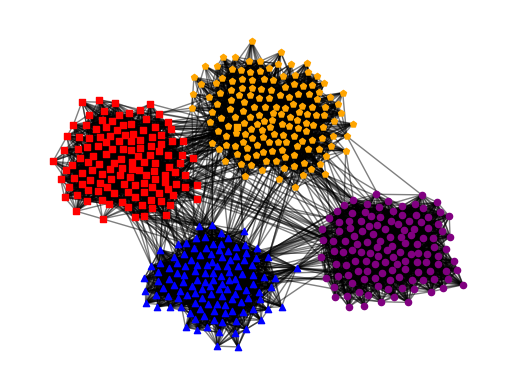

In [57]:
# Louvain Community Detection
N_louvain = 100
louvain_comm_arr = N_louvain*[None]
for i in range(N_louvain):
    louvain_comm_arr[i] = nx.community.louvain_communities(G)
louvain_lengths = [len(louvain_comm_arr[i]) for i in range(N_louvain)]
louvain_mod = [nx.community.modularity(G, louvain_comm_arr[i]) for i in range(N_louvain)]
louvain_cov, louvain_per = list(zip(*[nx.community.partition_quality(G, louvain_comm_arr[i]) for i in range(N_louvain)]))
print(f"Number of communities: {np.mean(louvain_lengths)} +/- {np.std(louvain_lengths)}")
print(f"Modularity of the partition: {np.mean(louvain_mod)} +/- {np.std(louvain_mod)}")
print(f"Coverage of the partition: {np.mean(louvain_cov)} +/- {np.std(louvain_cov)}")
print(f"Performace of the partition: {np.mean(louvain_per)} +/- {np.std(louvain_per)}")

def plot_louvain_communities(graph, save=False):
    """
    This function plots the Louvain communities detected in a given graph. Nodes within each community are visualized with different colors, and the shape of nodes is based on the 'Curso' attribute of the students.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.

    Returns:
        None: This function only displays the plot and does not return any value.
    """
    Cs = nx.community.louvain_communities(graph)
    node_positions, curso_attr, grupo_attr = plot_specifics(graph)
    # Plotting Louvain communities
    colors = ['purple', 'blue', 'red', 'orange'] # Community colors
    
    node_positions_str = nx.get_node_attributes(graph, ' _pos')
    node_positions = {}
    for node, array_str in node_positions_str.items():
        safe_str = array_str.replace('array', '')
        array_list = ast.literal_eval(safe_str)
        node_positions[node] = array_list
    
    curso_shapes = {1: '^', 2: 's', 3: 'p', 6: 'o'}

    # Visualize the communities with shapes based on "Curso"
    for i, community in enumerate(Cs):
        for node in community:
            curso = curso_attr[node]
            shape = curso_shapes.get(curso, 'o')  
            nx.draw_networkx_nodes(graph, node_positions, nodelist=[node], node_size=20, node_color=colors[i], node_shape=shape)

    # Draw edges
    nx.draw_networkx_edges(graph, node_positions, alpha=0.5)

    plt.axis('off')
    if save: plt.savefig("Figures/communities_louvain.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_louvain_communities(G, save=False)

Modularity: 0.7124000381253618
Coverage: 0.9641020258213499
Performance: 0.8109422321535229


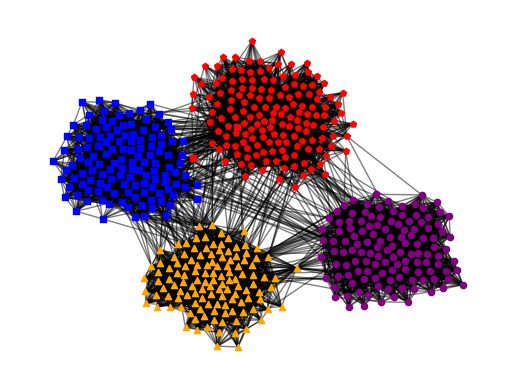

In [58]:
# Greedy modularity communities
communities_greedy = nx.community.greedy_modularity_communities(G)
Q_greedy = nx.community.modularity(G, communities_greedy)
greedy_cov, greedy_per = nx.community.partition_quality(G, communities_greedy)

print(f"Modularity: {Q_greedy}")
print(f"Coverage: {greedy_cov}")
print(f"Performance: {greedy_per}")

def plot_greedy_communities(graph, save=False):
    """
    This function plots the communities detected using the greedy modularity optimization algorithm in a given graph. Nodes within each community are visualized with different colors, and the shape of nodes is based on the 'Curso' attribute of the students.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.

    Returns:
        None: This function only displays the plot and does not return any value.
    """
    communities_greedy = nx.community.greedy_modularity_communities(graph)
    node_positions, curso_attr, grupo_attr = plot_specifics(graph) 
    curso_shapes = {1: '^', 2: 's', 3: 'p', 6: 'o'} # Shapes based on "Curso"
    colors = ['red', 'blue', 'purple', 'orange'] # Community colors

    # Visualize the communities with shapes based on "Curso"
    for i, community in enumerate(communities_greedy):
        for node in community:
            curso = curso_attr[node]
            shape = curso_shapes.get(curso, 'o')  # Default to 'o' (circle) if curso not found
            nx.draw_networkx_nodes(graph, node_positions, nodelist=[node], node_size=20, node_color=colors[i], node_shape=shape)

    # Draw edges
    nx.draw_networkx_edges(graph, node_positions, alpha=0.5)
    plt.axis('off')
    if save: plt.savefig("Figures/communities_greedy.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_greedy_communities(G, save=False)

# 4. Null Models: Erdös-Rényi & Barabási-Albert
We now repeat the general metrics and degree distribution analysis for the Erdös-Rényi and Barabási-Albert models.

## 4.1 General Network Metrics

In [60]:
def random_graph_properties(real_graph, model_type, iterations=10):
    """
    This function generates random graphs based on the specified model type (Erdos-Renyi or Barabasi-Albert) and calculates various properties for each generated graph. It then computes the average and standard deviation of these properties over multiple iterations.

    Args:
        real_graph (networkx.classes.graph.Graph): NetworkX graph object representing the real graph.
        model_type (str): The type of random graph model to use. It can be either 'ER' for Erdos-Renyi or 'BA' for Barabasi-Albert.
        iterations (int, optional): The number of iterations to perform for generating random graphs and calculating properties. Defaults to 10.

    Returns:
        dict: A dictionary containing the average and standard deviation of various properties for the generated random graphs. Keys represent the properties, and values are tuples containing the average and standard deviation.
    """
    properties = {
        'n': [], 'm': [], 'k_avg': [], 'k_std': [], 'density': [], 'avg_path_length': [], 'diameter': [], 
        'avg_clustering_coefficient': [], 'transitivity': [], 'r': [], 'b': []
    }

    n = real_graph.number_of_nodes()
    m = real_graph.number_of_edges()
    p = 2 * m / (n * (n - 1)) # Probability for ER model (density)
    m_avg = int(m / n) # Average degree for BA model

    for _ in range(iterations):
        if model_type == 'ER':
            # G_random = nx.gnm_random_graph(n, m) # Alternative way to generate ER graph with desired m
            G_random = nx.erdos_renyi_graph(n, p)
        elif model_type == 'BA':
            G_random = nx.barabasi_albert_graph(n, m_avg)
        else:
            raise ValueError("Unknown model type.")

        # Calculate properties for G_random
        n, m, k_avg, k_std, density, avg_path_length, diameter, avg_clustering_coefficient, transitivity, r, b = basic_properties(G_random)
        
        properties['n'].append(n); properties['m'].append(m); properties['k_avg'].append(k_avg); properties['k_std'].append(k_std)
        properties['density'].append(density); properties['avg_clustering_coefficient'].append(avg_clustering_coefficient)
        properties['transitivity'].append(transitivity); properties['diameter'].append(diameter)
        properties['avg_path_length'].append(avg_path_length); properties['r'].append(r); properties['b'].append(b)
        

    # Compute averages and standard deviations for each property
    avg_std_properties = {key: (np.mean(val), np.std(val)) for key, val in properties.items()}
    return avg_std_properties

avg_std_properties_ER = random_graph_properties(G, 'ER', iterations=10)
avg_std_properties_BA = random_graph_properties(G, 'BA', iterations=10)

In [10]:
avg_std_properties_ER, avg_std_properties_BA 

({'n': (534.0, 0.0),
  'm': (9535.6, 75.50920473690609),
  'k_avg': (35.713857677902624, 0.2828060102505845),
  'k_std': (5.769708170784476, 0.18440231690704828),
  'density': (0.06700536149700304, 0.0005305928897759545),
  'avg_path_length': (2.0179585555578976, 0.003652360766822589),
  'diameter': (3.0, 0.0),
  'avg_clustering_coefficient': (0.06726514515773413, 0.0011097481726611506),
  'transitivity': (0.06732677069200697, 0.0010703576105207308),
  'r': (-0.002391204100497195, 0.008435348765311348),
  'b': (1.4971578072044828e-10, 4.264010396852398e-11)},
 {'n': (534.0, 0.0),
  'm': (8789.0, 0.0),
  'k_avg': (32.91760299625468, 0.0),
  'k_std': (22.758061431329786, 0.43165093733920307),
  'density': (0.06175910505863917, 6.938893903907228e-18),
  'avg_path_length': (2.0779967816964255, 0.0034940613230256433),
  'diameter': (3.0, 0.0),
  'avg_clustering_coefficient': (0.13198283966921706, 0.0038992930613925216),
  'transitivity': (0.12664086461179547, 0.0016396548964108552),
  'r': 

In [61]:
# LaTeX Table
# Calculate properties for G
n_G, m_G, k_avg_G, k_std_G, density_G, avg_path_length_G, diameter_G, avg_clustering_coefficient_G, transitivity_G, r_G, b_G = G_properties

# Create a dataframe with the results
data = {
    r'\( \bar{l} \)': [avg_path_length_G, avg_std_properties_ER['avg_path_length'][0], avg_std_properties_BA['avg_path_length'][0]],
    r'\( D \)': [diameter_G, avg_std_properties_ER['diameter'][0], avg_std_properties_BA['diameter'][0]],
    r'\( \bar{C} \)': [avg_clustering_coefficient_G, avg_std_properties_ER['avg_clustering_coefficient'][0], avg_std_properties_BA['avg_clustering_coefficient'][0]],
    r'\( C \)': [transitivity_G, avg_std_properties_ER['transitivity'][0], avg_std_properties_BA['transitivity'][0]],
    r'\( r \)': [r_G, avg_std_properties_ER['r'][0], avg_std_properties_BA['r'][0]],
    r'\( b_e \)': [b_G, avg_std_properties_ER['b'][0], avg_std_properties_BA['b'][0]]
}

df = pd.DataFrame(data, index=[r'\( G \)', r'\( G_ER \)', r'\( G_BA \)'])
# df
latex_table = df.to_latex()
print(latex_table)

\begin{tabular}{lrrrrrr}
\toprule
 & \( \bar{l} \) & \( D \) & \( \bar{C} \) & \( C \) & \( r \) & \( b_e \) \\
\midrule
\( G \) & 2.650217 & 5.000000 & 0.523908 & 0.445115 & -0.055386 & 0.000000 \\
\( G_ER \) & 2.016050 & 3.000000 & 0.066934 & 0.066955 & -0.001715 & 0.000000 \\
\( G_BA \) & 2.078890 & 3.000000 & 0.130860 & 0.126110 & -0.021245 & 0.000000 \\
\bottomrule
\end{tabular}



## 4.2 Degree Distribution Analysis

In [63]:
n, m = G.number_of_nodes(), G.number_of_edges()
p = 2 * m / (n * (n - 1)) # Probability for ER model (density)
G_ER = nx.erdos_renyi_graph(n, p)
data = pd.Series([degree for node, degree in G_ER.degree()]) # for fitting
best_distibutions_G_ER = best_fit_distribution(data)

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

K-S Statistic (ncx2): 0.046787375314144675, p-value: 0.18694383730563113
K-S Statistic (betaprime): 0.04512472808412249, p-value: 0.22023489499312143
K-S Statistic (exponweib): 0.044152703182434194, p-value: 0.24168547366069915
K-S Statistic (powernorm): 0.04520325563923211, p-value: 0.21856711003509333
K-S Statistic (powerlognorm): 0.04524141585045571, p-value: 0.2177601330732647
K-S Statistic (skewnorm): 0.04421971308935013, p-value: 0.24015834966548189
K-S Statistic (genhyperbolic): 0.044798644089707795, p-value: 0.22726386685032918
K-S Statistic (norminvgauss): 0.04478404980560069, p-value: 0.22758237542015547
K-S Statistic (erlang): 0.04524803822792978, p-value: 0.21762032045536783
K-S Statistic (gamma): 0.045248066095928574, p-value: 0.21761973224651487


/Users/luisirisarri/opt/anaconda3/envs/Py11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3417: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value array(263.29027972).
  warnings.warn(


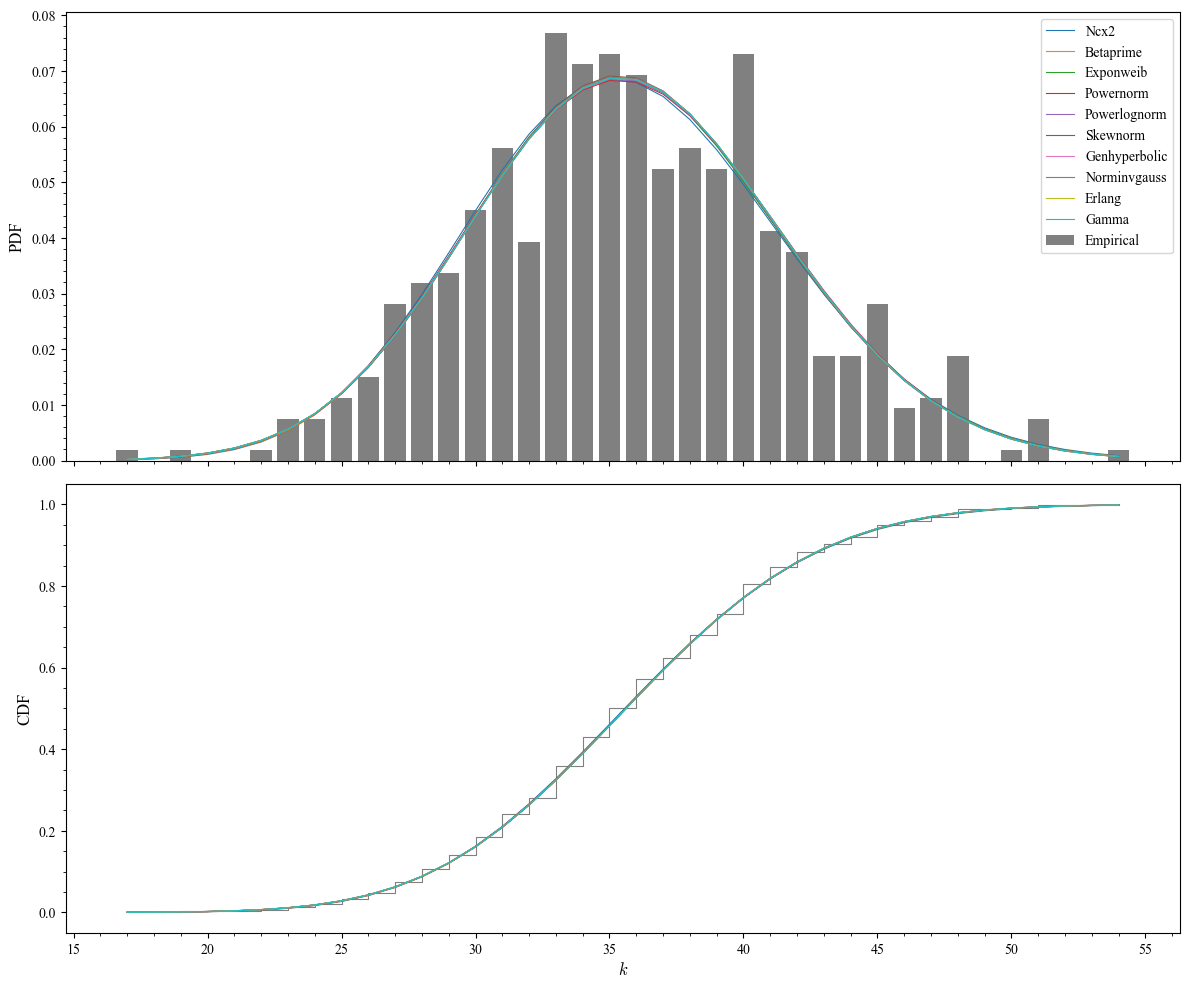

In [64]:
plotting_fitting(G_ER, best_distibutions_G_ER[0:10], save = False, filename = "Figures/G_ER_PDF_CDF.png")

In [65]:
G_BA = nx.barabasi_albert_graph(G.number_of_nodes(), int(G.number_of_edges() / G.number_of_nodes())) 
data = pd.Series([degree for node, degree in G_BA.degree()]) # for fitting
best_distibutions_G_BA = best_fit_distribution(data)

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

K-S Statistic (fatiguelife): 0.08087369674318826, p-value: 0.0017407276288813112
K-S Statistic (johnsonsu): 0.0815344604656283, p-value: 0.00155109271850114
K-S Statistic (genpareto): 0.10112359548085718, p-value: 3.309249477121181e-05


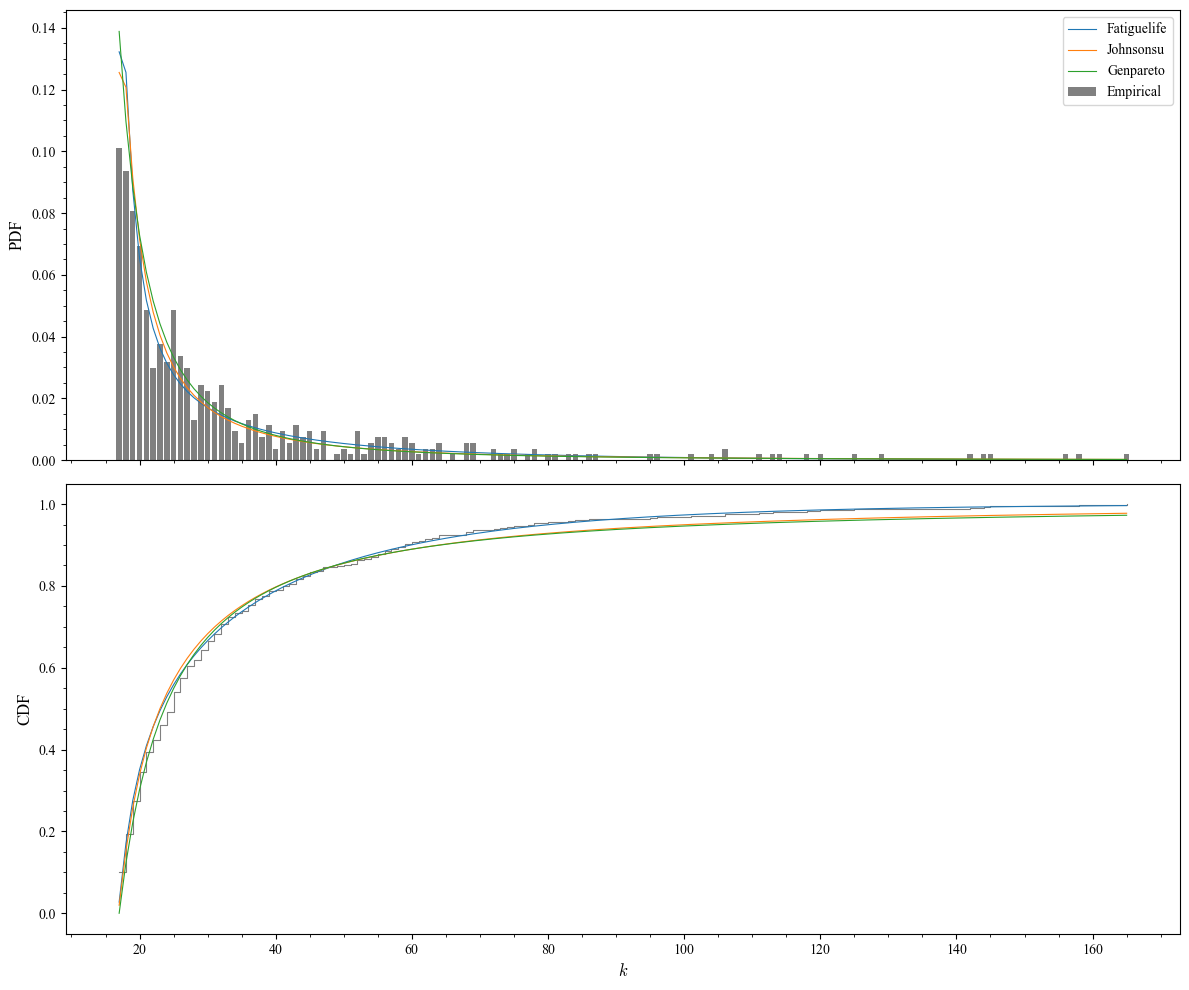

In [68]:
plotting_fitting(G_BA, best_distibutions_G_BA[0:3], save = False, filename = "Figures/G_BA_PDF_CDF.png")

### Theoretical fits of the Erdös-Rényi and Barabási-Albert Models
ER is expected to have a Poisson degree distribution, while BA is expected to have a power-law degree distribution. We can check this by plotting the degree distribution of the generated networks and comparing it to the expected distributions.

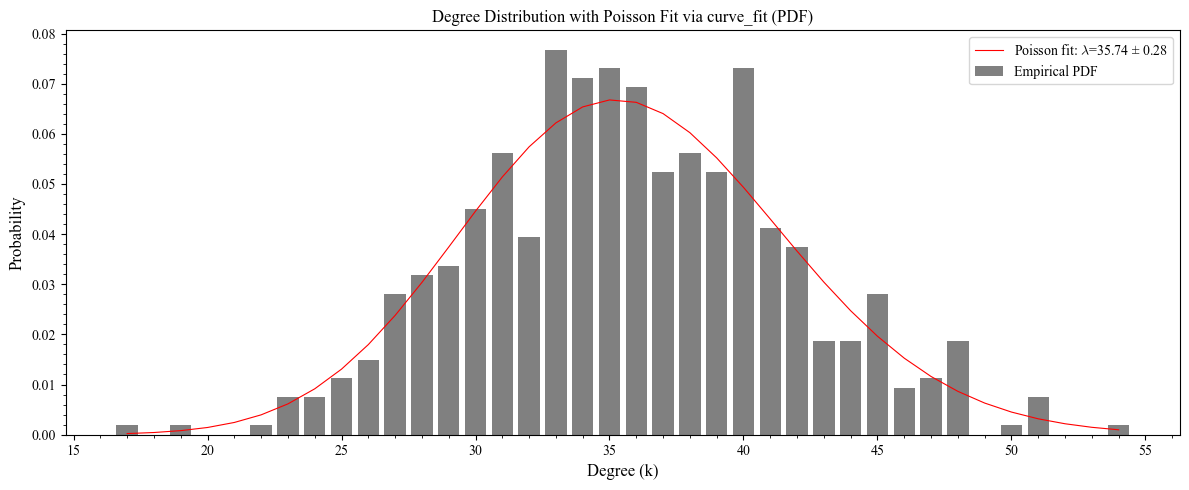

Fitted λ: 35.74 with standard error: 0.28


In [79]:
poisson_model = lambda k, lambda_val: poisson.pmf(k, lambda_val)

def poisson_fit_and_plot_curve_fit(graph, save=False, filename="poisson_fit_curve_fit.png"):
    """
    This function fits a Poisson distribution to the degree distribution of a given graph using the curve_fit method and plots the empirical degree distribution along with the fitted Poisson distribution.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.
        filename (str, optional): The filename to use when saving the plot. Defaults to "poisson_fit_curve_fit.png".

    Returns:
        None: This function only displays the plot and prints the fitted parameter along with its standard error.
    """
    k_values, p = PDF(graph)  # Use the previously defined PDF function
    list_of_degrees = np.array([degree for node, degree in graph.degree()])
    
    # Using curve_fit to fit the Poisson distribution to the data
    params, cov = curve_fit(poisson_model, k_values, p, p0=np.mean(list_of_degrees))
    lambda_val = params[0]
    lambda_se = np.sqrt(cov[0][0])  # Standard error of λ
    
    # Generate Poisson PDF with fitted parameter
    fitted_poisson_pdf = poisson_model(k_values, lambda_val)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(k_values, p, width=0.8, color='gray', label='Empirical PDF')
    ax.plot(k_values, fitted_poisson_pdf, 'r-', label=f'Poisson fit: $\lambda$={lambda_val:.2f} ± {lambda_se:.2f}')
    
    # Set titles, labels, and legends
    ax.set_title('Degree Distribution with Poisson Fit via curve_fit (PDF)')
    ax.set_xlabel('Degree (k)')
    ax.set_ylabel('Probability')
    ax.legend()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.tight_layout()
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Printing fitted parameter and its standard error
    print(f"Fitted λ: {lambda_val:.2f} with standard error: {lambda_se:.2f}")
    
poisson_fit_and_plot_curve_fit(G_ER, save=False, filename="Figures/poisson_fit_curve_fit.png")

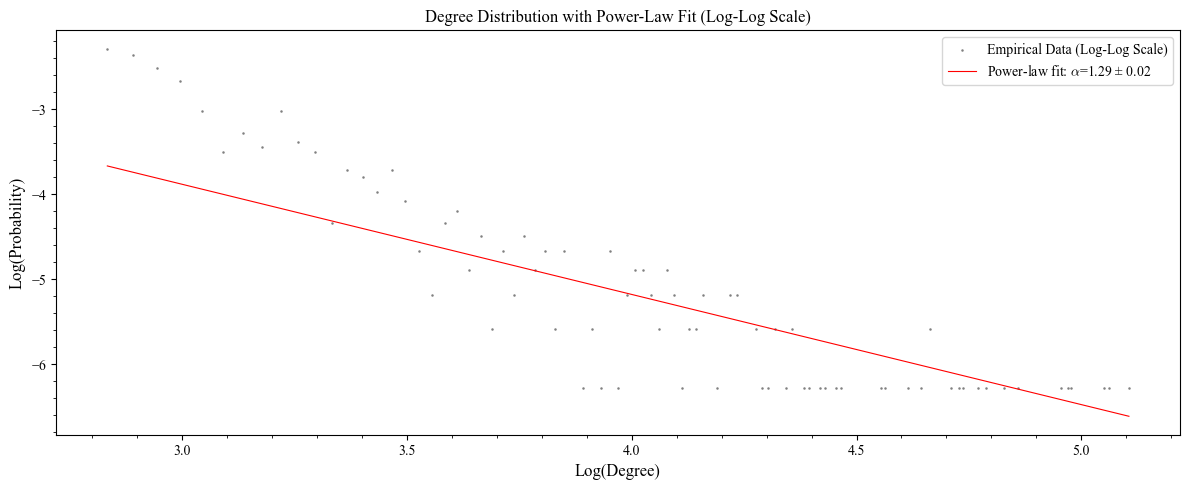

Fitted $\alpha$: 1.29 with standard error: 0.02


In [80]:
power_law_model = lambda k, alpha: k**(-alpha)

def log_power_law_fit_and_plot(graph, save=False, filename="power_law_fit_log_log.png"):
    """
    This function fits a power-law distribution to the degree distribution of a given graph using a log-log scale and plots the empirical degree distribution along with the fitted power-law distribution.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the graph.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.
        filename (str, optional): The filename to use when saving the plot. Defaults to "power_law_fit_log_log.png".

    Returns:
        None: This function only displays the plot and prints the fitted parameter along with its standard error.
    """
    k_values, p = PDF(graph)  # Use the previously defined PDF function
    
    # Filtering out zero values to avoid log(0)
    nonzero_indices = p > 0
    log_k_values = np.log(k_values[nonzero_indices])
    log_p = np.log(p[nonzero_indices])
    
    # Define the linear model for fitting in log-log space
    def linear_model(log_k, alpha):
        return -alpha * log_k
    
    # Using curve_fit to fit the linear model in log-log space
    params, cov = curve_fit(linear_model, log_k_values, log_p)
    alpha = params[0]
    alpha_se = np.sqrt(cov[0][0])  # Standard error of alpha
    
    # Plotting in log-log scale
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.scatter(log_k_values, log_p, color='gray', label='Empirical Data (Log-Log Scale)')
    ax.plot(log_k_values, linear_model(log_k_values, *params), 'r-', label=f'Power-law fit: $\\alpha$={alpha:.2f} ± {alpha_se:.2f}')
    
    # Set titles, labels, and legends
    ax.set_title('Degree Distribution with Power-Law Fit (Log-Log Scale)')
    ax.set_xlabel('Log(Degree)')
    ax.set_ylabel('Log(Probability)')
    ax.legend()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    plt.tight_layout()
    if save:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Printing fitted parameter and its standard error
    print(f"Fitted $\\alpha$: {alpha:.2f} with standard error: {alpha_se:.2f}")

log_power_law_fit_and_plot(G_BA, save=False, filename="Figures/power_law_fit_log_log.png")

### Plots for N realizations with errors

In [75]:
# Plotting with errors NO fitting
def get_average_distribution(dist_list):
    """
    This function calculates the average and standard deviation of a list of distributions.

    Args:
        dist_list (list of arrays): A list of arrays representing distributions.

    Returns:
        tuple: A tuple containing two arrays:
            - avg_dist: An array representing the average of the distributions at each index.
            - std_dist: An array representing the standard deviation of the distributions at each index.
    """
    N = len(dist_list)
    max_k = max(len(v) for v in dist_list)
    avg_dist, std_dist = np.empty(max_k), np.empty(max_k)
    
    for i in range(max_k):
        v = [dist_list[n][i] for n in range(N) if i < len(dist_list[n])]
        avg_dist[i] = np.mean(v)
        std_dist[i] = np.std(v)
    
    return avg_dist, std_dist

def plot_degree_distributions(graph, model='ER', N_networks=10, save=False):
    """
    This function plots the degree distributions (PDF and CDF) of a given graph along with the average and standard deviation of degree distributions obtained from random networks generated using Erdos-Renyi (ER) or Barabasi-Albert (BA) models.

    Args:
        graph (networkx.classes.graph.Graph): NetworkX graph object representing the real graph.
        model (str): The type of random graph model to use for generating networks. It can be either 'ER' for Erdos-Renyi or 'BA' for Barabasi-Albert.
        N_networks (int, optional): The number of random networks to generate and calculate average degree distributions. Defaults to 10.
        save (bool, optional): If True, saves the plot as an image file. Defaults to False.

    Returns:
        None: This function only displays the plot and does not return any value.
    """
    list_deg_pdfs = [None for _ in range(N_networks)]  
    list_deg_cdfs = [None for _ in range(N_networks)]  

    for i in range(N_networks):
        n = graph.number_of_nodes()
        m = graph.number_of_edges()

        if model == 'ER':
            p = 2 * m / (n * (n - 1))  # Probability for ER model
            G_model = nx.erdos_renyi_graph(n, p)
        elif model == 'BA':
            m0 = int(m / n)  # Initial number of edges to attach from a new node to existing nodes
            G_model = nx.barabasi_albert_graph(n, m0)
        else:
            raise ValueError("Unsupported model. Choose 'ER' or 'BA'.")

        k_values, pdf_vals = PDF(G_model)
        _, cdf_vals = CDF(G_model)
        list_deg_pdfs[i] = pdf_vals
        list_deg_cdfs[i] = cdf_vals

    k_vals, pdf_G = PDF(graph)
    _, cdf_G = CDF(graph)

    avg_pdf, pdf_err = get_average_distribution(list_deg_pdfs)
    avg_cdf, cdf_err = get_average_distribution(list_deg_cdfs)
    
    k_values_pdf = np.arange(len(avg_pdf))
    k_values_cdf = np.arange(len(avg_cdf))

    plt.figure(figsize=(12, 6))

    # Plot PDF
    plt.subplot(1, 2, 1)
    plt.plot(k_values_pdf, avg_pdf, c="blue", label="Average PDF")
    plt.fill_between(k_values_pdf, avg_pdf-pdf_err, avg_pdf+pdf_err, alpha=0.5, edgecolor="darkblue", facecolor="lightblue", label="Std. Dev.")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$k$")
    plt.ylabel("PDF")
    plt.legend()
    
    if model == 'BA':
        plt.xscale('log')
        plt.yscale('log')

    # Plot CDF
    plt.subplot(1, 2, 2)
    plt.plot(k_values_cdf, avg_cdf, c="green", label="Average CDF")
    plt.fill_between(k_values_cdf, avg_cdf-cdf_err, avg_cdf+cdf_err, alpha=0.5, edgecolor="darkgreen", facecolor="lightgreen", label="Std. Dev.")
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.xlabel(r"$k$")
    plt.ylabel("CDF")
    plt.legend()
    if model == 'BA': plt.xscale('log')

    plt.tight_layout()
    if save: plt.savefig(f'Figures/G_{model}_PDF_CDF.png', dpi=300, bbox_inches="tight")
    plt.show()

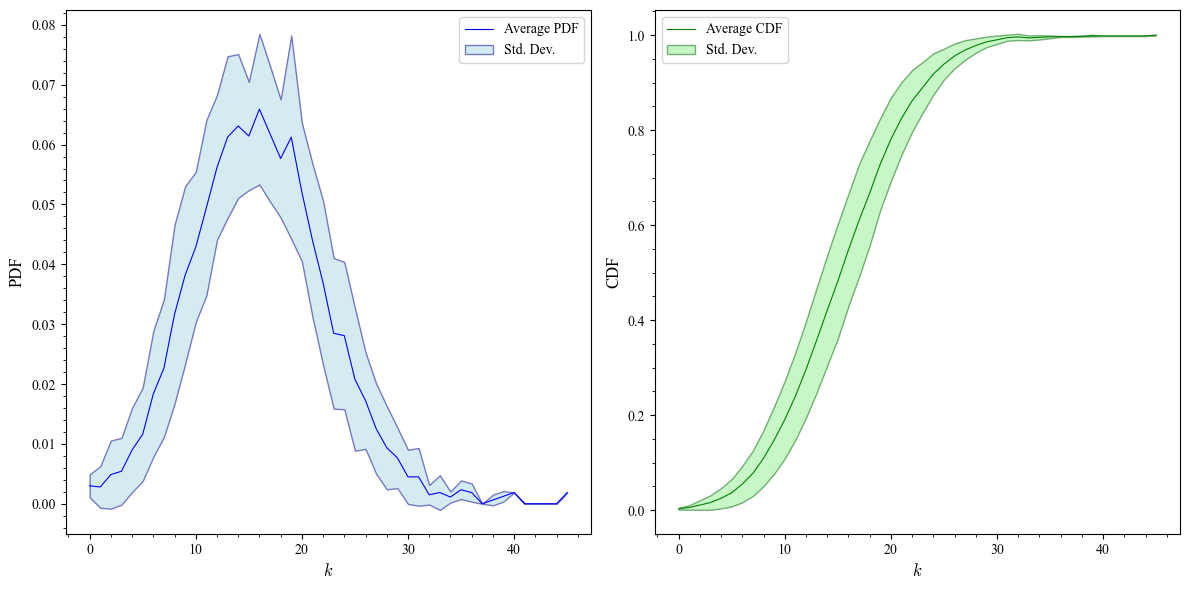

In [76]:
plot_degree_distributions(G, model='ER', N_networks=10, save=False)

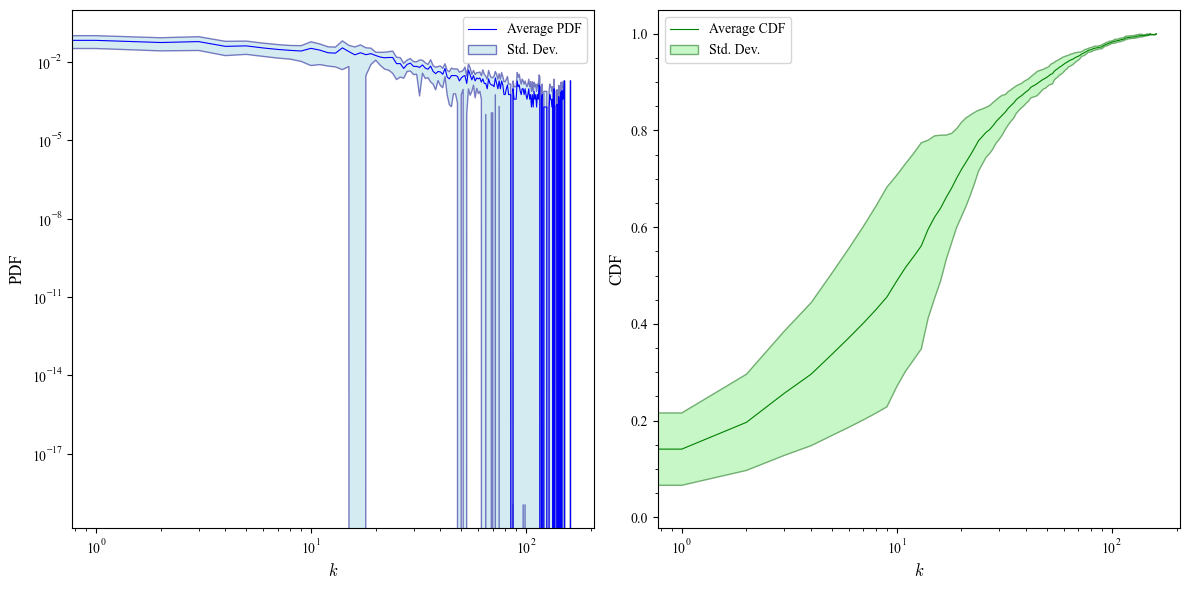

In [77]:
plot_degree_distributions(G, model='BA', N_networks=10, save=False)